# Predicción de ventas para Corporación Favorita

## Tabla de contenidos
[A. Definición del objetivo del problema](#a-definición-del-objetivo-del-problema)

[B. Recopilación de la información](#b-recopilación-de-la-información)
- [Días festivos](#días-festivos)
- [Petróleo](#petróleo)
- [Tiendas](#tiendas)
- [Train](#train)
- [Test](#test)
- [Transacciones](#transacciones)

[C. Overview y limpieza de la información](#c-overview-y-limpieza-de-la-información)
- [Días festivos](#limpieza-y-overview-días-festivos)
- [Petróleo](#limpieza-y-overview-petróleo)
- [Tiendas](#overview-tiendas)
- [Train](#overview-train)
- [Transacciones](#overview-transacciones)

[D. Visualización y relación entre features](#d-visualización-y-relación-entre-features)

[E. Análisis estadístico](#e-análisis-estadístico)

[F. Feature engineering](#f-feature-engineering)

[G. Tareas previas al modelo](#g-tareas-previas-al-modelo)

[H. Modelado](#h-modelado)

[I. Entrega de resultados](#i-entrega-de-resultado)


## A. Definición del objetivo del problema
Se busca obtener un modelo para predecir las ventas de Corporación Favorita, un supermercado ecuatoriano. Se busca que el modelo prediga con certeza las unidades de ventas para el supermercado con respecto al tiempo. 

## B. Recopilación de la información


### Días festivos
Los días festivos pueden proveer más tiempo para ir al supermercado o propiciar eventos familiares o de amigos que motiven a las personas a realizar más compras que no harían normalmente. 
| Columna | Descripción |
| --------|-------------|
| date | Fecha del día festivo |
| type | tipo de día festivo, si fue *Transferred* se celebró ese día cuando el día oficial es otro, si fue *Bridge* se agregó a otro |
| locale | A que nivel se celebró el día festivo (local, regional, nacional) |
| locale_name | en que localidad se celebró |
| description | descripción del día festivo |
| transfer | indica si el festivo se celebró en otra fecha, si el valor es verdadero la fecha en la que se celebró se indica con la columna **type** |

### Petróleo
Al ser un país dependiente del petróleo, el precio de este puede influir en las ventas del supermercado. 
| Columna | Descripción |
| --------|-------------|
| date | Fecha de la cotización del precio |
| dcoilwtico | precio del petroleo en la fecha |

### Tiendas
Información sobre cada tienda. 
| Columna | Descripción |
| --------|-------------|
| city | Ciudad |
| state | Estado |
| type | Tipo de tienda |
| cluster | agrupamiento de tiendas similares |

### Train
Datos de entrenamiento del modelo, se deberá usar la columna de **sales** como variable a predecir. 
| Columna | Descripción |
| --------|-------------|
| id | identificador único de la venta |
| date | Fecha de cada venta individual |
| store_nbr | tienda en la que se realizó la venta |
| family | familia de producto de la que se hizo la venta |
| sales | unidades vendidas de la familia de productos | 
| onpromotion | cantidad de artículos de la familia de productos que estaba en promoción | 

### Test
Datos para probar el modelo, igual que train menos la columna de **sales** ya que es la variable a predecir. 
| Columna | Descripción |
| --------|-------------|
| id | identificador único de la venta |
| date | Fecha de cada venta individual |
| store_nbr | tienda en la que se realizó la venta |
| family | familia de producto de la que se hizo la venta |
| onpromotion | cantidad de artículos de la familia de productos que estaba en promoción | 


### Transacciones

Datos de las transaccciones totales para cada tienda.   
| Columna | Descripción |
| --------|-------------|
| id | identificador único de la venta |
| date | Fecha de cada venta individual |
| store_nbr | tienda en la que se realizó la venta |
| family | familia de producto de la que se hizo la venta |
| onpromotion | cantidad de artículos de la familia de productos que estaba en promoción | 

## C. Overview y limpieza de la información

In [120]:
#Librerias de cajón.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Miscellaeneous
import re

#sklearn libraries
from sklearn.metrics import confusion_matrix

Debido a que la mayoría de las variables tienen los 100% completos, solamente se hará una ligera limpieza a Días Festivos y a Petróleo. Todas las variables se modificarán para que ahora su índice sea la fecha y se tratarán como variables tipo fecha de pandas.

In [121]:
def add_datepart(df, fldname, drop=True,errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_quarter_end', 'Is_quarter_start']
    for n in attr:
        if n == 'Week':
            df[targ_pre + n] = [ts.isocalendar().week for ts in fld]
        else:
            df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)

### Limpieza y overview Días festivos

In [122]:
holidays_df = pd.read_csv('./data/holidays_events.csv')
add_datepart(holidays_df, 'date', False)
holidays_df.tail(10)

,date,type,locale,locale_name,description,transferred,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True,2017,12,49,6,2,340,False,False
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,2017,12,49,8,4,342,False,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,2017,12,49,8,4,342,False,False
343,2017-12-21,Additional,National,Ecuador,Navidad-4,False,2017,12,51,21,3,355,False,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False,2017,12,51,22,4,356,False,False
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,12,51,22,4,356,False,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,12,51,23,5,357,False,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,12,51,24,6,358,False,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,2017,12,52,25,0,359,False,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False,2017,12,52,26,1,360,False,False


In [123]:
# Cambiamos el dataset para que tome como festivos en los días en los que se celebró.
holidays_df.loc[(holidays_df.transferred), 'type'] = 'None'
holidays_df.loc[(holidays_df.type == 'Transfer'), 'type'] = 'Holiday'
# holidays_df['date'] = pd.to_datetime(holidays_df['date'])
# holidays_df = holidays_df.set_index('date')
holidays_df.tail(10)


,date,type,locale,locale_name,description,transferred,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start
340,2017-12-06,None,Local,Quito,Fundacion de Quito,True,2017,12,49,6,2,340,False,False
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,2017,12,49,8,4,342,False,False
342,2017-12-08,Holiday,Local,Quito,Traslado Fundacion de Quito,False,2017,12,49,8,4,342,False,False
343,2017-12-21,Additional,National,Ecuador,Navidad-4,False,2017,12,51,21,3,355,False,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False,2017,12,51,22,4,356,False,False
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,12,51,22,4,356,False,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,12,51,23,5,357,False,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,12,51,24,6,358,False,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,2017,12,52,25,0,359,False,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False,2017,12,52,26,1,360,False,False


In [124]:
holidays_df.shape

(350, 14)

### Limpieza y overview Petróleo

In [125]:
oil_prices_df = pd.read_csv('./data/oil.csv')
oil_prices_df = oil_prices_df.dropna()
print(oil_prices_df.shape)
add_datepart(oil_prices_df,'date',False)
oil_prices_df.head()

(1175, 2)


,date,dcoilwtico,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start
1,2013-01-02,93.14,2013,1,1,2,2,2,False,False
2,2013-01-03,92.97,2013,1,1,3,3,3,False,False
3,2013-01-04,93.12,2013,1,1,4,4,4,False,False
4,2013-01-07,93.20,2013,1,2,7,0,7,False,False
5,2013-01-08,93.21,2013,1,2,8,1,8,False,False


### Overview Tiendas

In [126]:
stores_df = pd.read_csv('./data/stores.csv')
print(stores_df.shape)
stores_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Overview Train

In [127]:
train_df = pd.read_csv('./data/train.csv')
print(train_df.shape)
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.set_index('date')
train_df[250000:250010]

(3000888, 6)


,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-05-21,250000,23,PERSONAL CARE,93.000000,0
2013-05-21,250001,23,PET SUPPLIES,0.000000,0
2013-05-21,250002,23,PLAYERS AND ELECTRONICS,0.000000,0
2013-05-21,250003,23,POULTRY,125.645004,0
2013-05-21,250004,23,PREPARED FOODS,24.000000,0
2013-05-21,250005,23,PRODUCE,2.000000,0
2013-05-21,250006,23,SCHOOL AND OFFICE SUPPLIES,0.000000,0
2013-05-21,250007,23,SEAFOOD,12.900000,0
2013-05-21,250008,24,AUTOMOTIVE,9.000000,0


### Overview Transacciones

In [128]:
transactions_df = pd.read_csv('./data/transactions.csv')
print(transactions_df.shape)
transactions_df.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [129]:
train_df.reset_index(inplace = True)
train_group_df = train_df.groupby(by=['family','date','store_nbr']).sum().reset_index()
train_join_df = pd.merge(left = train_group_df, right = stores_df, on = 'store_nbr', how = 'inner')
train_join_df.drop(columns = 'id', inplace = True)
add_datepart(train_join_df,'date',False)
train_join_df

,family,date,store_nbr,sales,onpromotion,city,state,type,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end,Is_quarter_start
0,AUTOMOTIVE,2013-01-01,1,0.0,0,Quito,Pichincha,D,13,2013,1,1,1,1,1,False,True
1,AUTOMOTIVE,2013-01-02,1,2.0,0,Quito,Pichincha,D,13,2013,1,1,2,2,2,False,False
2,AUTOMOTIVE,2013-01-03,1,3.0,0,Quito,Pichincha,D,13,2013,1,1,3,3,3,False,False
3,AUTOMOTIVE,2013-01-04,1,3.0,0,Quito,Pichincha,D,13,2013,1,1,4,4,4,False,False
4,AUTOMOTIVE,2013-01-05,1,5.0,0,Quito,Pichincha,D,13,2013,1,1,5,5,5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,SEAFOOD,2017-08-11,54,0.0,0,El Carmen,Manabi,C,3,2017,8,32,11,4,223,False,False
3000884,SEAFOOD,2017-08-12,54,1.0,1,El Carmen,Manabi,C,3,2017,8,32,12,5,224,False,False
3000885,SEAFOOD,2017-08-13,54,2.0,0,El Carmen,Manabi,C,3,2017,8,32,13,6,225,False,False
3000886,SEAFOOD,2017-08-14,54,0.0,0,El Carmen,Manabi,C,3,2017,8,33,14,0,226,False,False


## D. Visualización y relación entre features

In [130]:
#Hacemos una función para desplegar la matriz de correlación en un heatmap.
def matTriangleHeatmap(df,title):
    plt.figure(figsize=(16,6))
    matCorr = df.corr()
    maskTri = np.triu(np.ones_like(matCorr, dtype = bool))
    heatmapTri = sns.heatmap(matCorr, mask = maskTri, vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')
    heatmapTri.set_title(title)

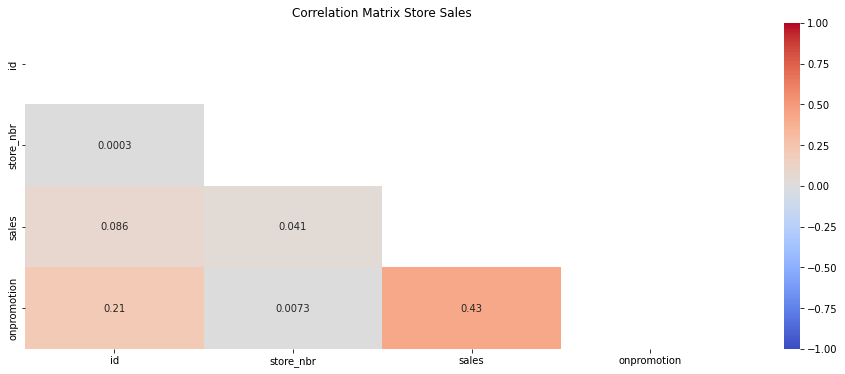

In [131]:
corr_mat = matTriangleHeatmap(train_df, 'Correlation Matrix Store Sales')
corr_mat

In [132]:
def bar_plot(df, labelx, labely):
    plt.figure(figsize=(16,9))
    sns.barplot(data = df, x = labelx, y = labely)

def time_series(df, labelx, labely):
    plt.figure(figsize=(16,9))
    sns.lineplot(data = df, x = labelx, y = labely)


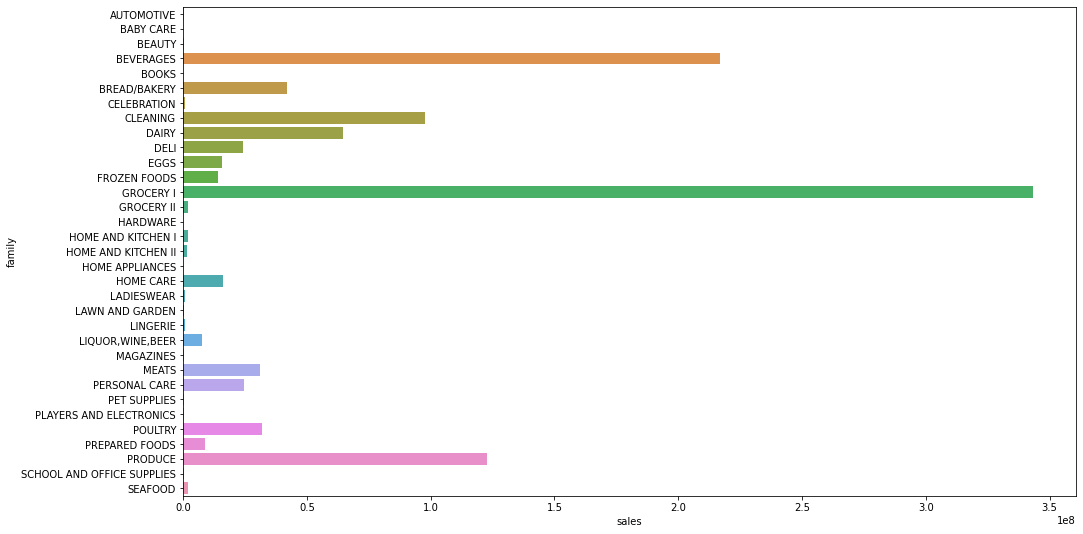

In [133]:
sales_df = train_join_df.groupby(by = 'family').sum().reset_index()
bar_plot(sales_df,'sales','family')

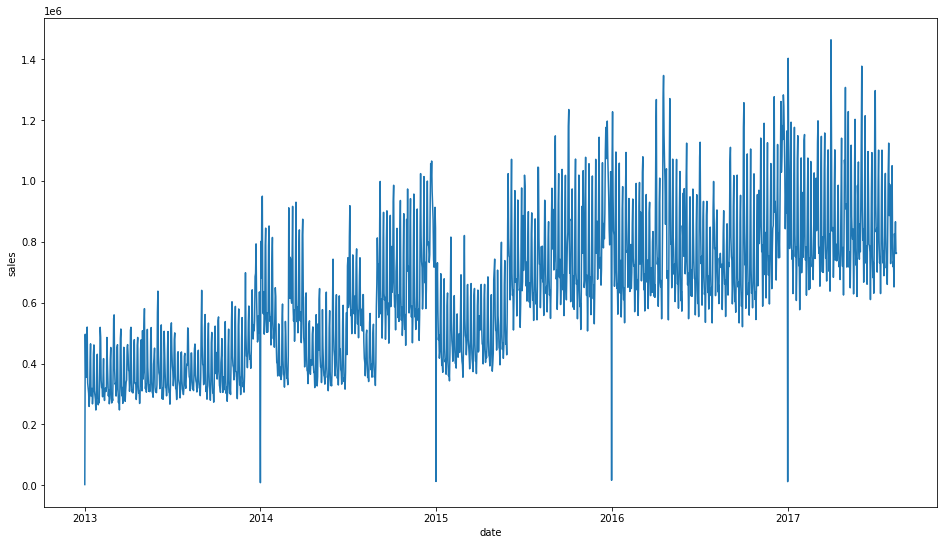

In [134]:
date_df = train_join_df.groupby(by = 'date').sum('sales').reset_index()
time_series(date_df, 'date', 'sales')

           date          sales  dcoilwtico  Year
0    2013-01-02  496092.417944       93.14  2013
1    2013-01-03  361461.231124       92.97  2013
2    2013-01-04  354459.677093       93.12  2013
3    2013-01-07  336122.801066       93.20  2013
4    2013-01-08  318347.777981       93.21  2013
...         ...            ...         ...   ...
1158 2017-08-09  734139.674010       49.59  2017
1159 2017-08-10  651386.911970       48.54  2017
1160 2017-08-11  826373.722022       48.81  2017
1161 2017-08-14  760922.406081       47.59  2017
1162 2017-08-15  762661.935939       47.57  2017

[1163 rows x 4 columns]


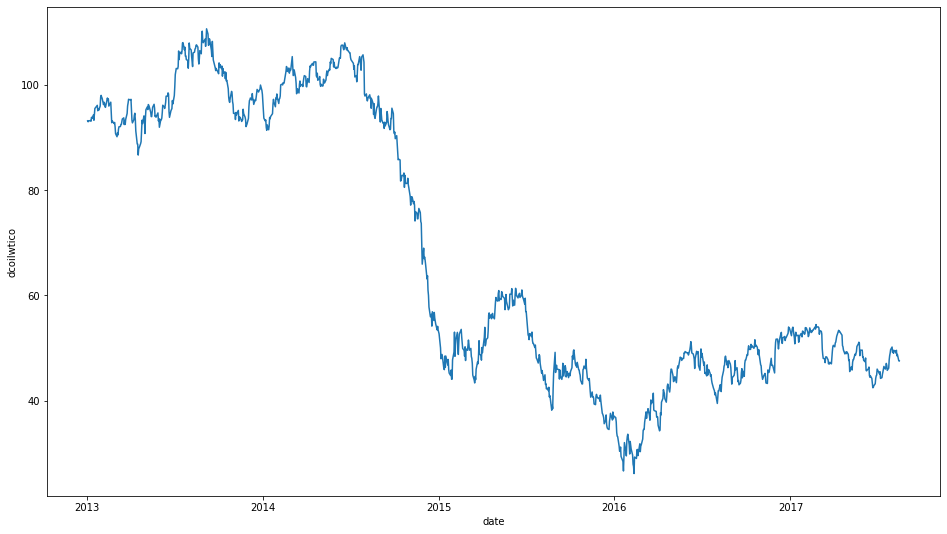

In [135]:
sales_and_oil_prices_per_date = pd.merge(left = train_df, right = oil_prices_df, on = 'date', how = 'inner')
sales_and_oil_prices_per_date = sales_and_oil_prices_per_date.groupby(by = 'date').agg({'sales': 'sum', 'dcoilwtico': 'first', 'Year': 'first'}).reset_index()
print(sales_and_oil_prices_per_date)
time_series(sales_and_oil_prices_per_date, 'date', 'dcoilwtico')

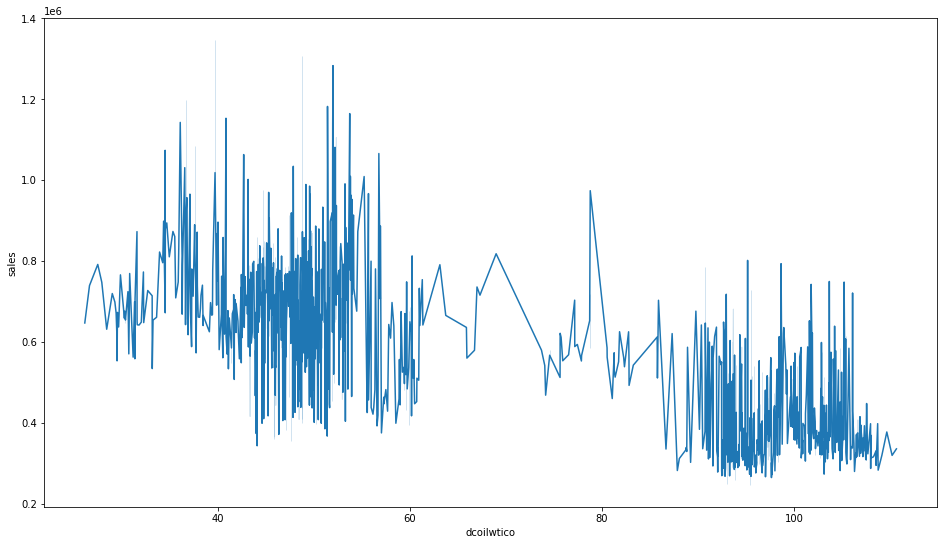

In [136]:
time_series(sales_and_oil_prices_per_date, 'dcoilwtico', 'sales')


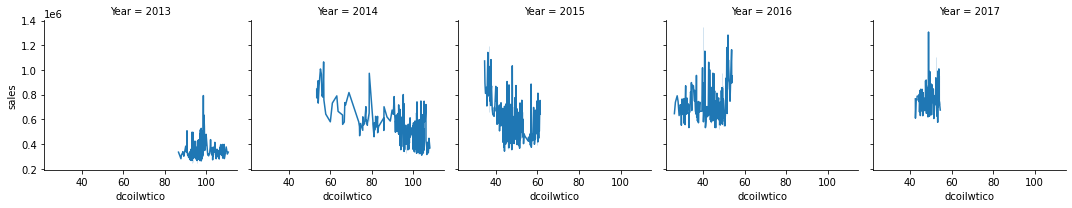

In [137]:
g = sns.FacetGrid(sales_and_oil_prices_per_date, col='Year')
g.map(sns.lineplot, "dcoilwtico", "sales")

## E. Análisis estadístico

In [138]:
train_join_df.describe()

,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00,2.014838e+03,6.207838e+00,2.524287e+01,1.563005e+01,2.997031e+00,1.733890e+02
std,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00,1.345518e+00,3.385668e+00,1.479467e+01,8.794789e+00,2.000740e+00,1.034388e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,2.014000e+03,3.000000e+00,1.300000e+01,8.000000e+00,1.000000e+00,8.500000e+01
50%,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,2.015000e+03,6.000000e+00,2.500000e+01,1.600000e+01,3.000000e+00,1.690000e+02
75%,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01,2.016000e+03,9.000000e+00,3.800000e+01,2.300000e+01,5.000000e+00,2.592500e+02
max,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,6.000000e+00,3.660000e+02


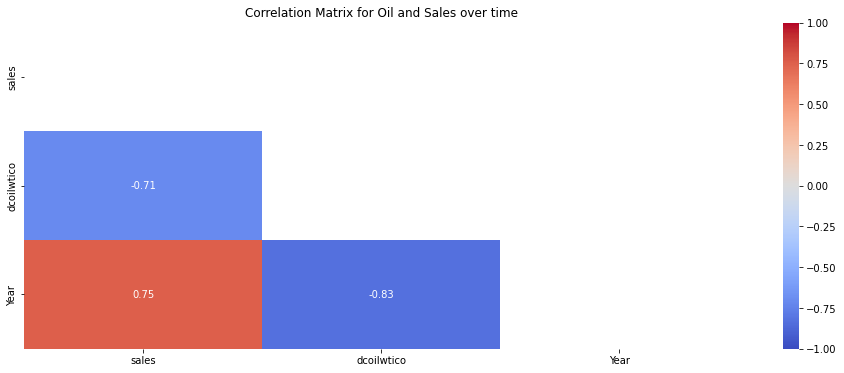

In [139]:
corr_mat_oil_sales = matTriangleHeatmap(sales_and_oil_prices_per_date, 'Correlation Matrix for Oil and Sales over time')

## F. Feature engineering

In [140]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(df,*colsname):
    label_encoding = LabelEncoder()
    for name in colsname:
        newName = "{}_encode".format(name)
        df[newName] = label_encoding.fit_transform(df[name])
        df.drop(columns = name, inplace = True)

train_join_df_encode = train_join_df.copy()
label_encoder(train_join_df_encode, 'Is_quarter_end','Is_quarter_start','family','city','state','type')
train_join_df_encode = pd.merge(left= train_join_df_encode, right=oil_prices_df[['date','dcoilwtico']], on='date', how='left')
train_join_df_encode['oil_price'] = train_join_df_encode['dcoilwtico'].shift().rolling(7, min_periods=1).mean().fillna(train_join_df_encode['dcoilwtico'])
train_join_df_encode.drop(['dcoilwtico'], axis=1, inplace=True)
train_join_df_encode.at[0, 'oil_price'] = 93.14
train_join_df_encode

,date,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end_encode,Is_quarter_start_encode,family_encode,city_encode,state_encode,type_encode,oil_price
0,2013-01-01,1,0.0,0,13,2013,1,1,1,1,1,0,1,0,18,12,3,93.140000
1,2013-01-02,1,2.0,0,13,2013,1,1,2,2,2,0,0,0,18,12,3,93.140000
2,2013-01-03,1,3.0,0,13,2013,1,1,3,3,3,0,0,0,18,12,3,93.140000
3,2013-01-04,1,3.0,0,13,2013,1,1,4,4,4,0,0,0,18,12,3,93.055000
4,2013-01-05,1,5.0,0,13,2013,1,1,5,5,5,0,0,0,18,12,3,93.076667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-11,54,0.0,0,3,2017,8,32,11,4,223,0,0,32,5,10,2,49.228000
3000884,2017-08-12,54,1.0,1,3,2017,8,32,12,5,224,0,0,32,5,10,2,49.076000
3000885,2017-08-13,54,2.0,0,3,2017,8,32,13,6,225,0,0,32,5,10,2,49.076000
3000886,2017-08-14,54,0.0,0,3,2017,8,33,14,0,226,0,0,32,5,10,2,49.076000


In [141]:
train_join_df_encode['is_holiday'] = train_join_df_encode.apply(lambda x: 1 if len(holidays_df[(holidays_df['Year'] == x['Year']) & (holidays_df["Month"] == x["Month"]) & (holidays_df["Day"] == x["Day"])]) > 0 else 0 , axis=1)
train_join_df_encode

,date,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end_encode,Is_quarter_start_encode,family_encode,city_encode,state_encode,type_encode,oil_price,is_holiday
0,2013-01-01,1,0.0,0,13,2013,1,1,1,1,1,0,1,0,18,12,3,93.140000,1
1,2013-01-02,1,2.0,0,13,2013,1,1,2,2,2,0,0,0,18,12,3,93.140000,0
2,2013-01-03,1,3.0,0,13,2013,1,1,3,3,3,0,0,0,18,12,3,93.140000,0
3,2013-01-04,1,3.0,0,13,2013,1,1,4,4,4,0,0,0,18,12,3,93.055000,0
4,2013-01-05,1,5.0,0,13,2013,1,1,5,5,5,0,0,0,18,12,3,93.076667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-11,54,0.0,0,3,2017,8,32,11,4,223,0,0,32,5,10,2,49.228000,1
3000884,2017-08-12,54,1.0,1,3,2017,8,32,12,5,224,0,0,32,5,10,2,49.076000,0
3000885,2017-08-13,54,2.0,0,3,2017,8,32,13,6,225,0,0,32,5,10,2,49.076000,0
3000886,2017-08-14,54,0.0,0,3,2017,8,33,14,0,226,0,0,32,5,10,2,49.076000,0


In [155]:
train_join_df_encode.to_csv('./data/train_join_df_encoded.csv', index=False)

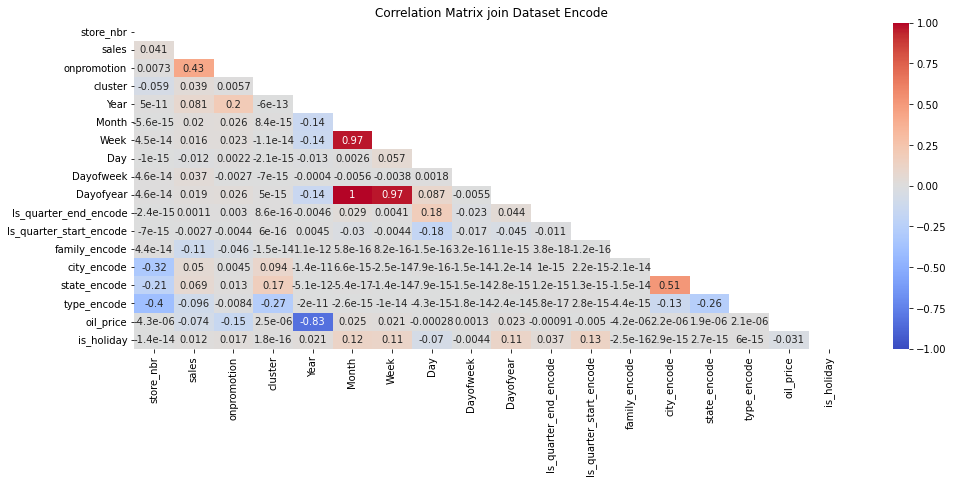

In [143]:
corr_mat_join_encode = matTriangleHeatmap(train_join_df_encode, 'Correlation Matrix join Dataset Encode')

In [153]:
train_join_df_encode.isnull().sum()

date                       0
store_nbr                  0
sales                      0
onpromotion                0
cluster                    0
Year                       0
Month                      0
Week                       0
Day                        0
Dayofweek                  0
Dayofyear                  0
Is_quarter_end_encode      0
Is_quarter_start_encode    0
family_encode              0
city_encode                0
state_encode               0
type_encode                0
oil_price                  0
is_holiday                 0
dtype: int64

## G. Tareas previas al modelo

In [165]:
train_dataset_clean = pd.read_csv('./data/train_join_df_encoded.csv')
train_dataset_clean.drop('date', axis=1, inplace=True)
train_dataset_clean

,store_nbr,sales,onpromotion,cluster,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_quarter_end_encode,Is_quarter_start_encode,family_encode,city_encode,state_encode,type_encode,oil_price,is_holiday
0,1,0.0,0,13,2013,1,1,1,1,1,0,1,0,18,12,3,93.140000,1
1,1,2.0,0,13,2013,1,1,2,2,2,0,0,0,18,12,3,93.140000,0
2,1,3.0,0,13,2013,1,1,3,3,3,0,0,0,18,12,3,93.140000,0
3,1,3.0,0,13,2013,1,1,4,4,4,0,0,0,18,12,3,93.055000,0
4,1,5.0,0,13,2013,1,1,5,5,5,0,0,0,18,12,3,93.076667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,54,0.0,0,3,2017,8,32,11,4,223,0,0,32,5,10,2,49.228000,1
3000884,54,1.0,1,3,2017,8,32,12,5,224,0,0,32,5,10,2,49.076000,0
3000885,54,2.0,0,3,2017,8,32,13,6,225,0,0,32,5,10,2,49.076000,0
3000886,54,0.0,0,3,2017,8,33,14,0,226,0,0,32,5,10,2,49.076000,0


In [167]:
#Train split
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(train_dataset_clean.drop('sales', axis=1), train_dataset_clean['sales'],train_size=0.8, random_state=43)
print(train_features.shape)
print(train_labels.shape)
#Unir al test de kaggle lo que se hizo en este modelo.


(2400710, 17)
(2400710,)


### Definición de funcion de evaluación de modelos

In [168]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## H. Modelado

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs', max_iter=50000,n_iter_no_change = 20)))  #neural network
models.append(('KNN', KNeighborsRegressor(n_jobs=-1))) 
models.append(('RF', RandomForestRegressor(n_estimators = 10, n_jobs=-1))) # Ensemble method - collection of many decision trees
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=5)
        
    cv_results = cross_val_score(model, train_features, train_labels, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()



LR: 0.206198 (0.003092)


## I. Entrega de resultado